In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class MWU(object):
    
    def __init__(self, eta, actions):
        self.eta = eta; #step size
        self.actions = actions; #assume finite action space with this being the number of actions
        self.w_t = np.ones(actions);
        self.p_t = self.w_t/sum(self.w_t)
        
    def play_action(self):
        #sample an action from the current distribution p_t
        return np.random.choice(self.actions, 1, p=list(self.p_t))[0]
    
    def update_distr(self, l_t):
        #update distribution based on loss vector l_t
        self.w_t = np.multiply(self.p_t,np.exp(self.eta*l_t))
        self.p_t = self.w_t/sum(self.w_t)
        return self.p_t

In [3]:
#sanity check
l_t = np.array([0.5,1])
T = 2000
eta = 1/np.sqrt(T)
regret = 0;
mwu = MWU(eta, l_t.shape[0])
mwu.p_t = np.array([0.99,0.01])
for t in xrange(T):
    a_t = mwu.play_action()
    regret += np.argmax(l_t) - l_t[a_t]   
    mwu.update_distr(l_t)
    if t%100 == 0:
        print mwu.p_t," ", t
print regret, " ", np.sqrt(T), " ", mwu.p_t

[ 0.98988871  0.01011129]   0
[ 0.96970195  0.03029805]   100
[ 0.9127649  0.0872351]   200
[ 0.77379014  0.22620986]   300
[ 0.52792181  0.47207819]   400
[ 0.26771821  0.73228179]   500
[ 0.10676072  0.89323928]   600
[ 0.03760462  0.96239538]   700
[ 0.01261302  0.98738698]   800
[ 0.00415878  0.99584122]   900
[ 0.00136341  0.99863659]   1000
[  4.46138728e-04   9.99553861e-01]   1100
[  1.45896329e-04   9.99854104e-01]   1200
[  4.77013888e-05   9.99952299e-01]   1300
[  1.55951291e-05   9.99984405e-01]   1400
[  5.09844269e-06   9.99994902e-01]   1500
[  1.66679827e-06   9.99998333e-01]   1600
[  5.44913460e-07   9.99999455e-01]   1700
[  1.78144207e-07   9.99999822e-01]   1800
[  5.82392486e-08   9.99999942e-01]   1900
204.5   44.72135955   [  1.92537509e-08   9.99999981e-01]


In [4]:
class Exp3(object):
    
    def __init__(self, gamma, num_arms):
        self.gamma = gamma
        self.num_arms = num_arms
        self.weights = np.ones(num_arms)
        self.p_t = np.zeros(num_arms)
        self.arm_t = 0
        for i in xrange(self.p_t.shape[0]):
            self.p_t[i] = (1-self.gamma)*(self.weights[i]/sum(self.weights)) + self.gamma/self.num_arms
    
    def play_action(self):
        self.arm_t = np.random.choice(self.num_arms, 1, p=list(self.p_t))[0]
        return self.arm_t
    
    def update_distr(self,reward_t):
        a_t = self.arm_t;
        x_t = reward_t/self.p_t[a_t]
        self.weights[a_t] = self.weights[a_t]*np.exp(self.gamma*x_t/self.num_arms)
        for i in xrange(self.p_t.shape[0]):
            self.p_t[i] = (1-self.gamma)*(self.weights[i]/sum(self.weights)) + self.gamma/self.num_arms
        return self.p_t
            

In [5]:
class Policy_regret_min(object):
    
    def __init__(self, actions, memory, T, no_reg_alg, C, q, eta_init, reward_type):
        self.tau = 1
        if memory>1:
            self.tau = max(memory,np.ceil(np.power(C,(-1.0)/(2-q))*np.power(T,(1.0-q)/(2.0-q)))) #depends on what type of no-regret algorithm is being played
        self.eta = eta_init*np.sqrt(1.0*self.tau/T) #roughly
        self.no_reg = no_reg_alg(self.eta, actions) #initialize the no-regret algorithm
        self.curr_action = -1;
        self.rewards = reward_type
        self.actions = actions
        self.p_t = np.ones(actions)/self.actions
    
    def play_action(self, curr_round):
        if curr_round%self.tau==0:
            self.curr_action = self.no_reg.play_action()
        return self.curr_action
    
    def update_distr(self, curr_round, reward):
#        self.rewards = np.add(self.rewards, reward)
        self.rewards += reward
        if (curr_round+1)%self.tau==0 or curr_round==0:
            self.p_t = self.no_reg.update_distr(self.rewards/self.tau)
#            self.rewards = np.zeros(self.actions)
            self.rewards = 0.0*reward
        return self.p_t

In [6]:
#sanity check for policy regret
l_t = np.array([0.5,1])
T = 2000
regret = 0
actions = 2
memory = 2
no_reg_alg = MWU
C = np.sqrt(14)
q = 0.5
eta_init = 1.0
pol_regret = Policy_regret_min(actions, memory, T, no_reg_alg, C, q, eta_init, np.zeros(actions))
p_t = [0.5,0.5]
for t in xrange(T):
    a_t = pol_regret.play_action(t)
    regret += np.argmax(l_t) - l_t[a_t]
    p_t = pol_regret.update_distr(t,l_t)
    if t%100 == 0:
        print p_t," ", t
print regret, " ", np.sqrt(T), " ", p_t

[ 0.5  0.5]   0
[ 0.45539752  0.54460248]   100
[ 0.40879447  0.59120553]   200
[ 0.36377494  0.63622506]   300
[ 0.32346299  0.67653701]   400
[ 0.2833371  0.7166629]   500
[ 0.24637614  0.75362386]   600
[ 0.21468393  0.78531607]   700
[ 0.18437466  0.81562534]   800
[ 0.15748636  0.84251364]   900
[ 0.1351774  0.8648226]   1000
[ 0.11445696  0.88554304]   1100
[ 0.09655801  0.90344199]   1200
[ 0.08203951  0.91796049]   1300
[ 0.06881609  0.93118391]   1400
[ 0.05759035  0.94240965]   1500
[ 0.04861575  0.95138425]   1600
[ 0.04054176  0.95945824]   1700
[ 0.0337611  0.9662389]   1800
[ 0.02838807  0.97161193]   1900
174.0   44.72135955   [ 0.02359015  0.97640985]


In [6]:
class Game:
    
    def __init__(self, utils, actions, memories, T, algs, Cs, qs, eta_inits, reward_types):
        self.utils = utils
        self.actions = actions
        self.memories = memories
        self.algs = algs
        self.Cs = Cs
        self.qs = qs
        self.eta_inits = eta_inits
        self.players = []
        self.curr_round = 0
        for i in xrange(len(memories)):
            num_arms = self.actions
            self.players.append(Policy_regret_min(self.actions[i],self.memories[i],T,self.algs[i],self.Cs[i],self.qs[i],self.eta_inits[i],reward_types[i]))
        
    def get_reward(self, alg, player_actions, player_i):
        reward = 'none'
        if alg=="mwu":
            lpa = [x for x in player_actions]
            reward = np.zeros(self.actions[player_i])
            for j in xrange(self.actions[player_i]):
                lpa[player_i] = j
                aa = tuple(lpa)
                reward[j] = self.utils[aa][player_i]
        elif alg=="exp3":
            reward = self.utils[player_actions][player_i]
        return reward
    
    def play_round(self,alg):
        player_actions = tuple(self.players[i].play_action(self.curr_round) for i in xrange(len(memories)))
        for i in xrange(len(memories)):
            reward = self.get_reward(alg, player_actions, i)
            self.players[i].update_distr(self.curr_round, reward)
        self.curr_round+=1
        return player_actions

round  100
p1 distr, [  4.77418543e-13   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.49049786  0.50950214] , p2 action, 1 , p2 reward, [ 0.  0.] 

round  101
p1 distr, [  3.59491210e-13   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.49049786  0.50950214] , p2 action, 1 , p2 reward, [ 0.  1.] 

round  200
p1 distr, [  9.51067487e-21   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.47932816  0.52067184] , p2 action, 1 , p2 reward, [ 0.  0.] 

round  201
p1 distr, [  1.09601586e-20   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.47932816  0.52067184] , p2 action, 0 , p2 reward, [ 0.  1.] 

round  300
p1 distr, [  7.90562402e-24   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.4681791  0.5318209] , p2 action, 1 , p2 reward, [ 0.  0.] 

round  301
p1 distr, [  5.95285287e-24   1.00000000e+00] , p1 action, 1 , p1 reward, [ 0.  0.]
p2 distr, [ 0.4681791  0.5318209] , p2 action, 1 , p

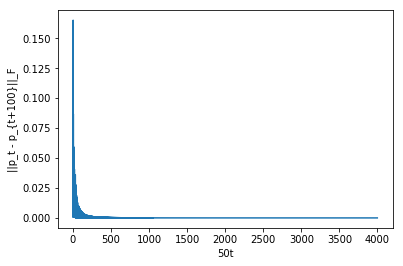

In [19]:
#utils = np.array([[(0.5,1.0),(0.0,0.0)],[(0.0,0.0),(0.5,0.5)]])
utils = np.array([[(1,2),(0.0,0.0)],[(0.0,0.0),(2,1)]])
actions = [2,2]
memories = [1,10]
T = 200000
algs = [MWU,MWU]
Cs = [np.sqrt(14),np.sqrt(14)]
qs = [0.5,0.5]
eta_inits = [np.power(T,0.34),1.0]
reward_types = [np.zeros(actions[0]),np.zeros(actions[1])]
game = Game(utils, actions, memories, T, algs, Cs, qs, eta_inits,reward_types)
game.play_round("mwu")
avr_distr = np.outer(np.array(game.players[0].p_t),np.array(game.players[1].p_t))
p1_distr = np.array(game.players[0].p_t)
p2_distr = np.array(game.players[1].p_t)
avr_emp_distr = np.zeros(utils.shape[:-1])
avr_emp_distrs = []
for i in xrange(T):
    actions = game.play_round("mwu")
    avr_distr += np.outer(np.array(game.players[0].p_t),np.array(game.players[1].p_t))
    p1_distr += np.array(game.players[0].p_t)
    p2_distr += np.array(game.players[1].p_t)
    avr_emp_distr[actions] += 1
    if game.curr_round%100 == 0 or (game.curr_round-1)%100 == 0:
        print "round ", game.curr_round
        print "p1 distr,", game.players[0].p_t, ", p1 action,", game.players[0].curr_action, ", p1 reward,", game.players[0].rewards
        print "p2 distr,", game.players[1].p_t, ", p2 action,", game.players[1].curr_action, ", p2 reward,", game.players[1].rewards, "\n"
        avr_emp_distrs.append(avr_emp_distr/game.curr_round)
print avr_distr/T, "\n"
print p1_distr/T, " ", p2_distr/T, "\n"
print avr_emp_distr/T
a = [x[0]-x[1] for x in zip(avr_emp_distrs[:-1],avr_emp_distrs[1:])]
plt.plot([np.linalg.norm(x) for x in a])
plt.ylabel('||p_t - p_{t+100}||_F')
plt.xlabel('50t')
plt.show()

[ 0.54060725  0.45939275]
[ 0.50099562  0.49900438]
round  100
p1 distr, [ 0.11029867  0.88970133] , p1 action, 1 , p1 reward, 0.0
p2 distr, [ 0.53135516  0.46864484] , p2 action, 0 , p2 reward, 0.0 

round  101
p1 distr, [ 0.12193457  0.87806543] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.53135516  0.46864484] , p2 action, 0 , p2 reward, 2.0 

round  200
p1 distr, [ 0.1455822  0.8544178] , p1 action, 1 , p1 reward, 0.0
p2 distr, [ 0.52397333  0.47602667] , p2 action, 0 , p2 reward, 2.0 

round  201
p1 distr, [ 0.1455822  0.8544178] , p1 action, 1 , p1 reward, 0.0
p2 distr, [ 0.52397333  0.47602667] , p2 action, 0 , p2 reward, 2.0 

round  300
p1 distr, [ 0.1442649  0.8557351] , p1 action, 1 , p1 reward, 0.0
p2 distr, [ 0.52678345  0.47321655] , p2 action, 1 , p2 reward, 0.0 

round  301
p1 distr, [ 0.13574222  0.86425778] , p1 action, 1 , p1 reward, 0.0
p2 distr, [ 0.52678345  0.47321655] , p2 action, 1 , p2 reward, 1.0 

round  400
p1 distr, [ 0.78916563  0.21083437] , p1 action, 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


 [ 0.98774522  0.01225478] , p2 action, 0 , p2 reward, 16.0 

round  7101
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774522  0.01225478] , p2 action, 0 , p2 reward, 18.0 

round  7200
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774658  0.01225342] , p2 action, 0 , p2 reward, 0.0 

round  7201
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774658  0.01225342] , p2 action, 0 , p2 reward, 2.0 

round  7300
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774757  0.01225243] , p2 action, 0 , p2 reward, 8.0 

round  7301
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774757  0.01225243] , p2 action, 0 , p2 reward, 10.0 

round  7400
p1 distr, [ 0.8974808  0.1025192] , p1 action, 0 , p1 reward, 0.0
p2 distr, [ 0.98774839  0.01225161] , p2 action, 0 , p2 reward, 14.0 

round  7401
p1 distr, [ 0.8974808  0.1025192] ,

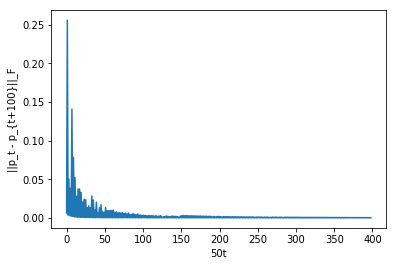

In [16]:
#utils = np.array([[(0.5,1.0),(0.0,0.0)],[(0.0,0.0),(0.5,0.5)]])
utils = np.array([[(1,2),(0.0,0.0)],[(0.0,0.0),(2,1)]])
actions = [2,2]
memories = [1,10]
T = 20000
algs = [Exp3,Exp3]
Cs = [np.sqrt(14),np.sqrt(14)]
qs = [0.5,0.5]
#eta_inits = [np.power(T,0.34),1.0]
eta_inits = [1.0,1.0]
reward_types = [0.0,0.0]
game = Game(utils, actions, memories, T, algs, Cs, qs, eta_inits,reward_types)
game.play_round("exp3")
print game.players[0].p_t
print game.players[1].p_t
avr_distr = np.outer(np.array(game.players[0].p_t),np.array(game.players[1].p_t))
p1_distr = np.array(game.players[0].p_t)
p2_distr = np.array(game.players[1].p_t)
avr_emp_distr = np.zeros(utils.shape[:-1])
avr_emp_distrs = []
for i in xrange(T):
    actions = game.play_round("exp3")
    avr_distr += np.outer(np.array(game.players[0].p_t),np.array(game.players[1].p_t))
    p1_distr += np.array(game.players[0].p_t)
    p2_distr += np.array(game.players[1].p_t)
    avr_emp_distr[actions] += 1
    if game.curr_round%100 == 0 or (game.curr_round-1)%100 == 0:
        print "round ", game.curr_round
        print "p1 distr,", game.players[0].p_t, ", p1 action,", game.players[0].curr_action, ", p1 reward,", game.players[0].rewards
        print "p2 distr,", game.players[1].p_t, ", p2 action,", game.players[1].curr_action, ", p2 reward,", game.players[1].rewards, "\n"
        avr_emp_distrs.append(avr_emp_distr/game.curr_round)
print avr_distr/T, "\n"
print p1_distr/T, " ", p2_distr/T, "\n"
print avr_emp_distr/T
a = [x[0]-x[1] for x in zip(avr_emp_distrs[:-1],avr_emp_distrs[1:])]
plt.plot([np.linalg.norm(x) for x in a])
plt.ylabel('||p_t - p_{t+100}||_F')
plt.xlabel('50t')
plt.show()